In [3]:
#smape
import numpy as np


def smape(y_true: np.array, y_pred: np.array) -> float:
    """Подсчет smape"""
    denominator = np.abs(y_true) + np.abs(y_pred)
    denominator = np.where(denominator == 0, 1, denominator) #избежим граничного случая деления на 0
    return np.mean(np.abs(y_true - y_pred) / ((denominator)/2))
y_true = 0.5
y_pred = 1.2
smape(y_true, y_pred)



0.8235289273359251

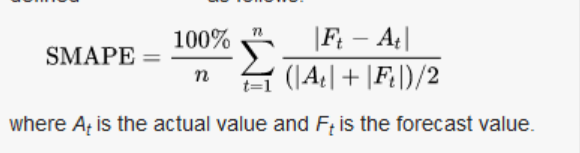

In [8]:
#fillna_with_mean
import pandas as pd
import numpy as np

def fillna_with_mean(df: pd.DataFrame, target: str, group: str) -> pd.DataFrame:
    """Fill NaN values with the mean value and then floor the result"""
    df_copy = df.copy()
    df_copy[target] = df_copy.groupby(group)[target].transform(lambda x: x.fillna(x.mean()))
    df_copy[target] = np.floor(df_copy[target])
    return df_copy


   group_col  target_col
0          3         1.0
1          0        25.0
2          4         NaN
3          5        42.0
4          3        53.0
5          2         NaN


In [1]:
#Elasticity search

import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

def elasticity_df(df: pd.DataFrame) -> pd.DataFrame:
    """Расчет эластичности"""
    data = df.copy()
    data = data.drop_duplicates(subset=['sku'])
    data['log_prices'] = np.log(data['price'])
    data['log_qty'] = np.log(data['qty'])
    X = data['log_prices'].values.reshape(-1, 1)
    y = data['log_qty'].values
    model = LinearRegression()
    model.fit(X,y)
    data['elasticity'] = model.score(X, y)
    #a = model.coef_[0]
    #data['sales_volume'] = data['qty'] * data['price']
    #r2_squared = r2_score(data['sales_volume'], data['price'])
    #data['elasticity'] = a * (data['price']/data['sales_volume'])*r2_squared
    drop_columns = [
        'dates',
        'price',
        'log_qty',
        'log_prices',
        'qty'
    ]
    data = data.drop(columns=drop_columns)
    data = data.reset_index(drop=True)
    return data


In [1]:
#valid emails
import re
from typing import List


def valid_emails(strings: List[str]) -> List[str]:
    """Take list of potential emails and returns only valid ones"""

    valid_email_regex = r"^[a-zA-Z0-9_.+-]+@[a-zA-Z0-9-]+\.[a-zA-Z]{2,}$"

    def is_valid_email(email: str) -> bool:
        return bool(re.fullmatch(valid_email_regex, email))

    emails = []
    for email in strings:
        if is_valid_email(email):
            emails.append(email)

    return emails


In [1]:
#Динамическое ценообразование
#sku-уникальный id товара, gmv-(цена)*(кол-во проданных штук), stock - число единиц товара на складе
#price-цена товара
#задача-постобработка предсказаний модели
import math
import pandas as pd
def limit_gmv(df: pd.DataFrame) -> pd.DataFrame:
    """Прогноз gmv"""
    data = df.copy()
    pr_ed  = data['gmv'] / data['price']
    if pr_ed > data['stock'] and isinstance(pr_ed):
        data['gmv'] = data['stock'] * data['price']
    elif pr_ed > data['stock'] and not isinstance(pr_ed):
        data['gmv'] = math.floor(pr_ed) * data['price']
    elif data['stock'] == 0:
        data['gmv'] = math.floor(pr_ed) * data['price']
    else:
        data['gmv'] = pr_ed * data['price']
    return data

In [4]:
from typing import List

def cumulative_gain(relevance: List[float], k: int) -> float:
    """Score is cumulative gain at k (CG@k)
    Parameters
    ----------
    relevance: List[float]
        Relevance labels (Ranks)
    k : int
        Number of elements to be counted
    Returns
    -------
    score : float
    """
    score = 0
    for i in range(min(len(relevance), k)):
        score += relevance[i]
    return score

relevance = [0.99, 0.94, 0.88, 0.74, 0.71, 0.68]
k = 5
print(cumulative_gain(relevance, k))


4.26


In [9]:
#cumulative gain - 2
from typing import List
import math

def discounted_cumulative_gain(relevance: List[float], k: int, method) -> float:
    """Score is cumulative gain at k (CG@k)
    Parameters
    ----------
    relevance: List[float]
        Relevance labels (Ranks)
    k : int
        Number of elements to be counted
    Returns
    -------
    score : float
    """
    score = 0
    if method == 'standard':
        for i in range(min(len(relevance), k)):
            score += relevance[i]/ math.log2(i + 2)
    else:
        for i in range(min(len(relevance), k)):
            score += (2**relevance[i] - 1)/ math.log2(i + 2)
    return score

relevance = [0.99, 0.94, 0.88, 0.74, 0.71, 0.68]
k = 5
method = 'standard'
print(discounted_cumulative_gain(relevance, k, method))


2.6164401144680056


In [2]:
import math
from typing import List

def normalized_dcg(relevance: List[float], k: int, method) -> float:
    """Normalized Discounted Cumulative Gain (nDCG) at k
    Parameters
    ----------
    relevance: List[float]
        Relevance labels (Ranks)
    k : int
        Number of elements to be counted
    Returns
    -------
    score : float
    """
    def dcg(relevance, k, method):
        score = 0
        if method == 'standard':
            for i in range(min(len(relevance), k)):
                score += (2**relevance[i] - 1) / math.log2(i + 2)
        else:
            for i in range(min(len(relevance), k)):
                score += relevance[i] / math.log2(i + 2)
        return score

    sorted_relevance = sorted(relevance, reverse=True)
    idcg_score = dcg(sorted_relevance, k, method)
    dcg_score = dcg(relevance, k, method)

    if idcg_score == 0:
        return 0  # Avoid division by zero

    return dcg_score / idcg_score

relevance = [0.99, 0.94, 0.74, 0.88, 0.71, 0.68]
k = 5
method = 'standard'
print(normalized_dcg(relevance, k, method))


0.9953188437374725


In [ ]:
#asymmetric metrics
import numpy as np
def turnover_error(y_true: np.array, y_pred: np.array) -> float:
    
    return error

In [9]:
import time 
import multiprocessing
import numpy as np 
from sklearn.ensemble import RandomForestClassifier 

#Generate a matrix 50000x1000 
size = 50000
num_cores = multiprocessing.cpu_count()
X = np.random.random((size, 1000)) 
y = np.random.randint(2, size=size) 

for n_jobs in range(1, num_cores+1): 
    start_time = time.time() 
    rfc = RandomForestClassifier(n_jobs=n_jobs)
    rfc.fit(X, y)
    end_time = time.time()

    print(f'n_jobs: {n_jobs} | time fitting: {end_time - start_time:.4f}') 

KeyboardInterrupt: 

In [10]:
from time import sleep
from typing import List
from joblib import Parallel, delayed

def parallel(n_jobs=-1):
    """Parallel computing"""
    result = Parallel(
        n_jobs=n_jobs, backend="multiprocessing",verbose=5 * n_jobs
    )(delayed(sleep)(0.2) for _ in range(50))
    return result

print(parallel(n_jobs=1))
print(parallel(n_jobs=2))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:   10.0s finished
[Parallel(n_jobs=2)]: Using backend MultiprocessingBackend with 2 concurrent workers.


[None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None]


[Parallel(n_jobs=2)]: Done   1 tasks      | elapsed:    3.5s
[Parallel(n_jobs=2)]: Done   4 tasks      | elapsed:    3.7s
[Parallel(n_jobs=2)]: Done   9 tasks      | elapsed:    4.3s
[Parallel(n_jobs=2)]: Done  14 tasks      | elapsed:    4.7s
[Parallel(n_jobs=2)]: Done  21 tasks      | elapsed:    5.5s
[Parallel(n_jobs=2)]: Done  28 tasks      | elapsed:    6.1s
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:    7.2s
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    8.0s


[None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None]


[Parallel(n_jobs=2)]: Done  50 out of  50 | elapsed:    8.4s finished


In [11]:
#multiprocessing

import re
from string import punctuation
import time 
import multiprocessing
import pandas as pd
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from joblib import Parallel, delayed
from time import sleep
from typing import List

def preprocess_text(text):
    """Text preprocessing"""
    lemmatizer = WordNetLemmatizer()
    text = str(text)
    text = re.sub(r"https?://[^,\s]+,?", "", text)
    text = re.sub(r"@[^,\s]+,?", "", text)

    stop_words = stopwords.words("english")
    transform_text = text.translate(str.maketrans("", "", punctuation))
    transform_text = re.sub(" +", " ", transform_text)

    text_tokens = word_tokenize(transform_text)

    lemma_text = [
        lemmatizer.lemmatize(word.lower()) for word in text_tokens
    ]
    cleaned_text = " ".join(
        [str(word) for word in lemma_text if word not in stop_words]
    )
    return cleaned_text

def clear_data(source_path: str, target_path: str, n_jobs: int):
    """Parallel process df

    Parameters
    ----------
    source_path : str
        Path to load dataframe from

    target_path : str
        Path to save dataframe to
    n_jobs : int
        Count of job to process
    """
    data = pd.read_parquet(source_path)
    data = data.copy().dropna().reset_index(drop=True)

    cleaned_text_list = Parallel(n_jobs=n_jobs, backend="multiprocessing", verbose = 5 * n_jobs)(delayed(preprocess_text)
                                                                                                (text) for text in data['text'])
    data["cleaned_text"] = cleaned_text_list
    data.to_parquet(target_path)


In [ ]:
#hello pytest
from typing import List
import metrics
import unittest


def profit(revenue: List[float], costs: List[float]) -> float:
    return sum(revenue) - sum(costs)


def margin(revenue: List[float], costs: List[float]) -> float:
    return (sum(revenue) - sum(costs)) / sum(revenue)


def markup(revenue: List[float], costs: List[float]) -> float:
    return (sum(revenue) - sum(costs)) / sum(costs)

def test_profit() -> None:
    assert metrics.profit([1,2,3], [1,1,1]) == 3

def test_margin() -> None:
    assert metrics.margin([10,20,30],[5,10,15]) == 0.5
    
def test_markup() -> None:
    assert metrics.markup([10,20,30], [5,10,15]) == 1.0
 

In [ ]:
#decision tree
import numpy as np

def mse(y: np.ndarray) -> float:
    """Compute the mean squared error of a vector."""
    mse = 0
    for _ in range(len(y)):
        mse += (y[_] - np.mean(y))**2
    mse = mse/len(y)
    return mse


def weighted_mse(y_left: np.ndarray, y_right: np.ndarray) -> float:
    """Compute the weighted mean squared error of two vectors."""
    #расчет mse left
    mse_left = 0
    mse_right = 0
    
    for i in range(len(y_left)):
        mse_left += (y_left[i] - np.mean(y_left))**2
    mse_left = mse_left/len(y_left)
    
    for j in range(len(y_right)):
        mse_right += (y_right[j] - np.mean(y_right))**2
    mse_right = mse_right/len(y_right)
    mse_weighted = 0
    total_length = len(y_left) + len(y_right)
    mse_weighted = (mse_left*len(y_left) + mse_right*len(y_right))/total_length
    
    return mse_weighted

In [ ]:
import numpy as np

def split(X: np.ndarray, y: np.ndarray, feature: int) -> float:
    """Расчет критерия разбиения с использованием MSE"""
    best_threshold = None
    best_mse = float('inf')
    
    # Получаем уникальные значения признака
    unique_values = np.unique(X[:, feature])
    
    # Сортируем уникальные значения
    unique_values.sort()
    
    # Пробегаем по всем уникальным значениям и находим наилучшее разбиение
    for i in range(1, len(unique_values)):
        threshold = (unique_values[i-1] + unique_values[i]) / 2
        left_indices = X[:, feature] <= threshold
        right_indices = X[:, feature] > threshold
        
        left_mse = mse(y[left_indices])
        right_mse = mse(y[right_indices])
        
        mse_value = (sum(left_indices) * left_mse + sum(right_indices) * right_mse) / len(y)
        
        if mse_value < best_mse:
            best_mse = mse_value
            best_threshold = threshold
    
    return best_threshold


In [ ]:
#valid email 
import re
from typing import List

def valid_emails(strings: List[str]) -> List[str]:
    """Take list of potential emails and returns only valid ones"""
    valid_email_regex = re.compile(r"^[a-zA-Z0-9_.+-]+@[a-zA-Z0-9-]+\.[a-zA-Z]{2,}$")

    def is_valid_email(email: str) -> bool:
        return bool(valid_email_regex.fullmatch(email))

    emails = [email for email in strings if is_valid_email(email)]
    
    return emails
